In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec, Phrases
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/imdb-review-dataset"))

# Any results you write to the current directory are saved as output.

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


['imdb_master.csv']


In [2]:
import warnings
import sys
warnings.filterwarnings('ignore')
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

In [3]:
train_data = pd.read_csv('../input/word2vec-nlp-tutorial/labeledTrainData.tsv', sep='\t')[['sentiment','review']]
unlabeled_data = pd.read_csv("../input/word2vec-nlp-tutorial/unlabeledTrainData.tsv", error_bad_lines=False, sep='\t')
test_data = pd.read_csv("../input/word2vec-nlp-tutorial/testData.tsv", sep='\t')

additional_data = pd.read_csv('../input/imdb-review-dataset/imdb_master.csv',encoding="latin-1")[['label','review']].rename(columns={'label':'sentiment'})
additional_data['sentiment'] = additional_data['sentiment'].map({'neg':0, 'pos':1, 'unsup':-1})
additional_data = additional_data[~(additional_data['review'].isin(train_data['review']))]
additional_data = additional_data[~(additional_data['review'].isin(test_data['review']))]
additional_data = additional_data[~(additional_data['review'].isin(unlabeled_data['review']))]

train_data = pd.concat([train_data,additional_data[additional_data['sentiment']!=-1]],ignore_index=True)
unlabeled_data = pd.concat([unlabeled_data,additional_data[additional_data['sentiment']==-1].drop(columns='sentiment')],ignore_index=True)
del additional_data

b'Skipping line 43043: expected 2 fields, saw 3\n'


In [4]:
train_data.sentiment.value_counts()

0    25810
1    24518
Name: sentiment, dtype: int64

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english")) 

def clean_review(text: str):
    # 1. Remove HTML
    text = BeautifulSoup(text, "lxml").get_text()
    # 2. Remove non-letters
    r = re.compile(r'[^A-Za-z\s]')
    text = re.sub(r, " ", text)
    # 3. Convert to lower case
    text = text.lower()
    text = word_tokenize(text)
    text = [lemmatizer.lemmatize(x) for x in text]
    text = [lemmatizer.lemmatize(x, 'v') for x in text] 
    text = [word for word in text if not word in stop_words]
    return text

print('train_data - start')
train_data['review'] = train_data['review'].apply(lambda x: clean_review(x))
print('train_data - end')
print('unlabeled_data - start')
unlabeled_data['review'] = unlabeled_data['review'].apply(lambda x: clean_review(x))
print('unlabeled_data - end')
print('test_data - start')
test_data['review'] = test_data['review'].apply(lambda x: clean_review(x))
print('test_data - end')

train_data - start
train_data - end
unlabeled_data - start
unlabeled_data - end
test_data - start
test_data - end


In [6]:
train_data.shape,unlabeled_data.shape,test_data.shape

((50328, 2), (75673, 2), (25000, 2))

In [7]:
all_reviews = np.hstack((train_data['review'],unlabeled_data['review'],test_data['review']))


In [8]:
bigrams = Phrases(sentences=all_reviews)
trigrams = Phrases(sentences=bigrams[all_reviews])

In [9]:
print(trigrams[bigrams['space station near the solar system'.split()]])

['space_station', 'near', 'the', 'solar_system']


In [10]:
embedding_vector_size = 256
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[all_reviews]],
    size = embedding_vector_size,
    min_count=3, window=5, workers=4)

In [11]:
print("Vocabulary size:", len(trigrams_model.wv.vocab))

Vocabulary size: 120331


In [12]:
trigrams_model.wv.most_similar('galaxy')

[('planet', 0.7405821084976196),
 ('continent', 0.7067104578018188),
 ('wormhole', 0.7008349895477295),
 ('portal', 0.6928468346595764),
 ('starship', 0.6907411813735962),
 ('spacecraft', 0.6872769594192505),
 ('sphere', 0.678518533706665),
 ('space_station', 0.671869695186615),
 ('orbit', 0.6677983999252319),
 ('spaceship', 0.6667606830596924)]

In [13]:
trigrams_model.wv.doesnt_match(['galaxy', 'starship', 'planet', 'dog'])

'dog'

In [14]:

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

Using TensorFlow backend.


In [15]:
%%time
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[train_data['review']]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)
CPU times: user 12min 3s, sys: 524 ms, total: 12min 3s
Wall time: 12min 4s


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    train_data['sentiment'],
    test_size=0.05,
    shuffle=True,
    random_state=42)

In [17]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

In [18]:
model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 256)          30804736  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)      

In [19]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=500,
    epochs=10)

Instructions for updating:
Use tf.cast instead.
Train on 47811 samples, validate on 2517 samples
Epoch 1/10
47811/47811 [==============================] - 49s 1ms/step - loss: 0.6279 - acc: 0.6404 - val_loss: 0.4945 - val_acc: 0.7608
Epoch 2/10
47811/47811 [==============================] - 45s 951us/step - loss: 0.4773 - acc: 0.7837 - val_loss: 0.4184 - val_acc: 0.8157
Epoch 3/10
47811/47811 [==============================] - 45s 933us/step - loss: 0.4080 - acc: 0.8200 - val_loss: 0.3837 - val_acc: 0.8252
Epoch 4/10
47811/47811 [==============================] - 46s 956us/step - loss: 0.3592 - acc: 0.8449 - val_loss: 0.3496 - val_acc: 0.8502
Epoch 5/10
47811/47811 [==============================] - 45s 935us/step - loss: 0.3159 - acc: 0.8671 - val_loss: 0.3566 - val_acc: 0.8419
Epoch 6/10
47811/47811 [==============================] - 46s 954us/step - loss: 0.2757 - acc: 0.8865 - val_loss: 0.3361 - val_acc: 0.8562
Epoch 7/10
47811/47811 [==============================] - 45s 932us/ste

In [20]:
%%time
y_train_pred = model.predict_classes(X_train)
y_test_pred = model.predict_classes(X_test)

CPU times: user 6min 30s, sys: 1min 55s, total: 8min 25s
Wall time: 4min 42s


In [21]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names=['Positive', 'Negative'], vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sns.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

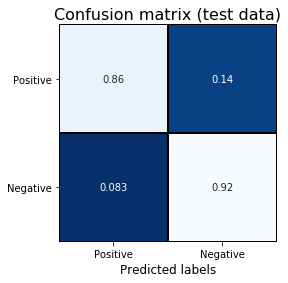

In [22]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plot_confusion_matrix(y_test, y_test_pred, ax=ax, #normed=False,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

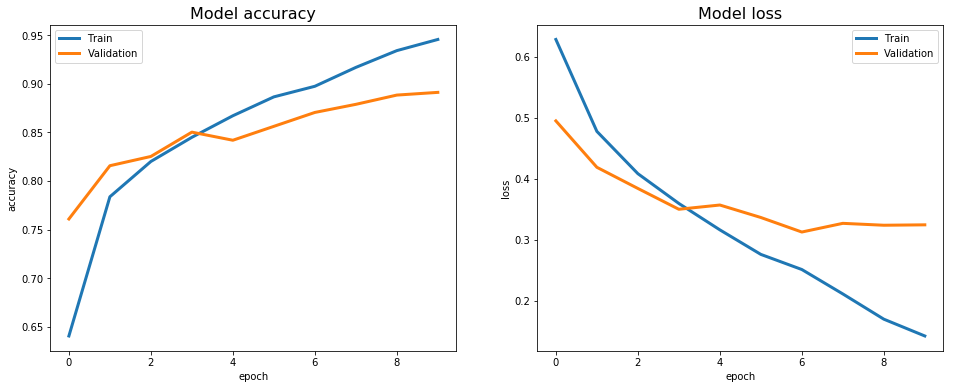

In [23]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['acc'], label='Train', linewidth=3)
axis1.plot(history.history['val_acc'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [24]:
print('Convert sentences to sentences with ngrams...', end='\r')
X_submit = trigrams[bigrams[test_data['review']]]
print('Convert sentences to sentences with ngrams... (done)')
X_sub = pad_sequences(
    sequences=vectorize_data(X_submit, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')
Y_sub_pred = model.predict_classes(X_sub)
test_data['sentiment'] = Y_sub_pred
test_data.to_csv('submission.csv', index=False, columns=['id','sentiment'])

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)
